In [ ]:
import sys
import subprocess

try:
    import fiona
    import shapely
    import pyproj
    import rtree
    import geopandas as gpd
    import pandas as pd
    print('The required modules are installed')
except ModuleNotFoundError:
    print('The required modules are NOT installed')

    # 👇️ optionally install module
    python = sys.executable
    subprocess.check_call(
        [[python, '-m', 'pip', 'install', 'fiona'],
        [python, '-m', 'pip', 'install', 'shapely'],
        [python, '-m', 'pip', 'install', 'pyproj'],
        [python, '-m', 'pip', 'install', 'rtree'],
        [python, '-m', 'pip', 'install', 'geopandas'],
        [python, '-m', 'pip', 'install', 'pandas']],
        stdout=subprocess.DEVNULL
    )
finally:
    import fiona
    import shapely
    import pyproj
    import rtree
    import geopandas as gpd
    import pandas as pd

In [ ]:
import sys

## A function to show the progress of the analysis
def print_progress_bar(index, total, label):
    ## Progress bar width
    n_bar = 50
    progress = index / total
    sys.stdout.write('\r')
    ## Message
    sys.stdout.write(f"[{'|' * int(n_bar * progress):{n_bar}s}] {int(100 * progress)}%  {label}")
    sys.stdout.flush()

In [ ]:
## Find the last segment of each channel, where it joins a bigger channel (drain_nodes).
def find_drain_nodes(shp_file):
    drain_nodes = shp_file[(shp_file['OrderStrah'] < shp_file['TargetOrd'])]
    drain_nodes = drain_nodes[['STREAM', 'OrderStrah']]
    drain_nodes = drain_nodes.sort_values(by=['OrderStrah'], ascending=True)
    return drain_nodes

In [ ]:
## Detect and join all small links (or watersheds, if the inputs are a polygons) that make-up a channel
def merge_leve1(feature_segments, d_nods):
    ## Find all up stream segment(s) of a feature
    def find_up_stream_segments(id):
        up_segms = feature_segments[feature_segments['Target'] == id]
        return up_segms

    """
        Seperate all features with Strahler order 1, as they are already in one piece.
        These will be joined to the rest of merged features when returning the finall
            channel network or watersheds layer.
    """
    drain_nodes = d_nods[d_nods['OrderStrah'] > 1]
    merged_features = feature_segments[feature_segments['OrderStrah'] == 1]

    """
        Find all segments that make up a featur (excluding their contributery channels)
            and merge them into a single feature.
        For example, if the feature (channel or wayteshed) has Strahler order 4, the
            product of this function will not include smaller channels with Strahler
            order 3, 2, and 1 that contribute to it.
    """
    counter = 0
    total = len(drain_nodes)
    ## Iterate over drain nodes
    for id in drain_nodes['STREAM']:
        segments = feature_segments[feature_segments['STREAM'] == id]
        order = int(segments.OrderStrah.iloc[0])
        
        ## Find up stream links of the current link in a channel
        up_segments = find_up_stream_segments(id)
        segments = pd.concat([segments, up_segments], ignore_index=True)
        while len(up_segments) > 0:
            lev_n_segments = gpd.GeoDataFrame()
            for lev_n_id in up_segments['STREAM']:
                lev_n_segment = find_up_stream_segments(lev_n_id)
                lev_n_segments = pd.concat([lev_n_segments, lev_n_segment], ignore_index=True)

            up_segments = lev_n_segments
            segments = pd.concat([segments, up_segments], ignore_index=True)

            segments = segments[segments['OrderStrah'] == order]
            
        ## Dissolve all sections into one feature
        segment = segments.dissolve()
        segment['STREAM'] = int(id)

        ## Add the current feature to the results
        merged_features = pd.concat([merged_features, segment], ignore_index=True)

        """
            Find all channels that drain into the current channel and change their "Target"
                attribute to the ID ("STREAM") of the current channel. 
        """
        for trg in segments['STREAM']:
            merged_features.loc[merged_features['Target'] == trg, 'Target'] = int(id)

        counter = counter + 1
        print_progress_bar(counter, total, "Percent of the data has been processed")

    ## Join attributes of the original shapefile to the merged shapefile
    merged_features = gpd.GeoDataFrame(merged_features[['STREAM', 'Target', 'geometry']])
    merged_features = merged_features.merge(feature_segments[['STREAM', 'OrderStrah', 'TargetOrd']], \
                                            on='STREAM', suffixes=(None,'_T'))
    merged_features = merged_features[['STREAM', 'OrderStrah', 'Target', 'TargetOrd', 'geometry']]
    
    return merged_features

In [ ]:
## Detect and join all channels (or watersheds, if the inputs are a polygons) that drain from the current point
def merge_leve2(feature_segments, d_nods):
    ## Find the up stream segment(s) of a channel.
    def find_up_stream_segments(id):
        up_channels = feature_segments[feature_segments['Target'] == id]
        return up_channels

    """
        Seperate all features with Strahler order 1, as they are already in one piece.
        These will be joined to the rest of merged features when returning the finall
            channel network or watersheds layer.
    """
    merged_features = feature_segments[feature_segments['OrderStrah'] == 1]
    ## Get the Strahler order of the biggest stream in the catchment
    max_order = max(drain_nodes['OrderStrah']) 

    """
        Find all segments that make up a featur (INCLUDING their contributery channels)
            and merge them into a single feature.
        For example, if the feature (channel or wayteshed) has Strahler order 4, the
            product of this function WILL INCLUDE smaller channels with Strahler
            order 3, 2, and 1 that contribute to it.
    """
    counter = 0
    total = len(drain_nodes)
    for id in drain_nodes['STREAM']:
        segments = feature_segments[feature_segments['STREAM'] == id]
        
        ## Find up stream links of the current link in a channel
        up_segments = find_up_stream_segments(id)
        segments = pd.concat([segments, up_segments], ignore_index=True)
        while len(up_segments) > 0:
            lev_n_segments = gpd.GeoDataFrame()
            for lev_n_id in up_segments['STREAM']:
                lev_n_segment = find_up_stream_segments(lev_n_id)
                lev_n_segments = pd.concat([lev_n_segments, lev_n_segment], ignore_index=True)

            up_segments = lev_n_segments
            segments = pd.concat([segments, up_segments], ignore_index=True)
        
        ## Dissolve all sections into one feature
        segment = segments.dissolve()
        segment['STREAM'] = int(id)
        
        ## Add the current feature to the results
        merged_features = pd.concat([merged_features, segment], ignore_index=True)

        counter = counter + 1
        print_progress_bar(counter, total, "Percent of the data has been processed")

    ## Join attributes of the original shapefile to the merged shapefile
    merged_features = gpd.GeoDataFrame(merged_features[['STREAM', 'Target', 'geometry']])
    merged_features = merged_features.merge(feature_segments[['STREAM', 'OrderStrah', 'TargetOrd']],
                                            on='STREAM', suffixes=(None,'_T'))
    merged_features = merged_features[['STREAM', 'OrderStrah', 'Target', 'TargetOrd', 'geometry']]

    return merged_features

In [ ]:
import numpy as np
## Calculate the traveling distance from a drain point, along the channel network, to the last drain point in the channel network
def calc_dis_to_drain(channel_links):
    d_nods = channel_links[(channel_links['OrderStrah'] < channel_links['TargetOrd'])]#.iloc[:10]
    counter = 0
    total = len(d_nods)
    
    """
        Find all segments that make up a channel and merge them into a single channel. For example, a channel with order 6 will include all its upper channel segment plus all channels with smaller order
    """
    channels_l = gpd.GeoDataFrame()
    for index, channel in d_nods.iterrows():
        counter2 = 0
        channel_id = channel.STREAM
        n_channel_id = channel.Target
        target_channel = channel_links[channel_links['STREAM'] == n_channel_id]
        l_to_h = 0

        while len(target_channel) > 0:
            l_to_h = l_to_h + float(target_channel.length)
            n_channel_id = target_channel.Target.iloc[0]
            target_channel = channel_links[channel_links['STREAM'] == n_channel_id]

            if n_channel_id == 200002:
                break
            if counter2 == 300:
                break
            counter2 = counter2 + 1

        counter = counter + 1
        print_progress_bar(counter, total, "Percent of the data has been processed")
        
        ## Add the current feature to the results
        channel['Dis2EndP'] = l_to_h
        channels_l = pd.concat([channels_l, channel], axis=1, ignore_index=True)
    
    channels_l = channels_l.transpose()
    
    ## Convert the channels to a point geodataframe that represents the drain points
    geom_dis2drain =  channels_l.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
    last_vertices = geom_dis2drain.apply(lambda x: x[-1])
    x_coords = last_vertices.apply(lambda x: x[0])
    y_coords = last_vertices.apply(lambda x: x[1])
#     pts_coords = pd.concat([x_coords.rename('XCoords'), y_coords.rename('YCoords')], axis=1)
    
    ## Join attributes of the original shapefile to the resulted shapefile
    channels_l = channels_l.merge(channel_links[['STREAM', 'OrderStrah', 'TargetOrd']],
                                  on='STREAM', suffixes=(None,'_T'))
    channels_l = channels_l[['STREAM', 'OrderStrah', 'Target', 'TargetOrd', 'Dis2EndP']]
    
    ## Create the geopandas point geodataframe 
    pt_drains = gpd.GeoDataFrame(channels_l, \
                                 geometry=gpd.points_from_xy(x_coords, y_coords), \
                                 crs=channel_links.crs)
    return pt_drains

,STREAM,OrderStrah,Target,TargetOrd,geometry
0,57,1,60,2,"LINESTRING (1582362.017 5480386.908, 1582364.0..."
1,59,1,60,2,"LINESTRING (1582182.017 5480266.908, 1582184.0..."
2,60,2,30,7,"LINESTRING (1582434.017 5480268.908, 1582434.4..."
3,61,7,30,7,"LINESTRING (1582446.017 5480094.908, 1582451.8..."
4,65,2,61,7,"LINESTRING (1582396.017 5480076.908, 1582398.0..."
...,...,...,...,...,...
23504,30,7,21,8,"LINESTRING (1582512.017 5480188.908, 1582529.7..."
23505,168,5,172,5,"LINESTRING (1581646.017 5478960.908, 1581650.0..."
23506,374,2,266,7,"LINESTRING (1582102.017 5477530.908, 1582102.4..."
23507,21038,3,21202,2,"LINESTRING (1576390.017 5447410.908, 1576392.0..."


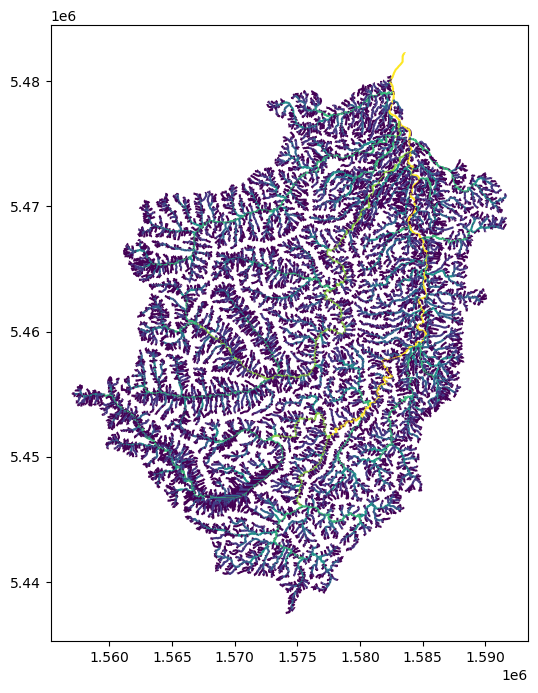

In [3]:
## Read and represent the shapefile
f_dir = './Takaka_DEM2m_2h_20m_CN_Modified.shp'
features = gpd.read_file(f_dir)
features.plot(column='OrderStrah', figsize=(12, 8)) ## 'OrderStrah' can be changed to any attribute in the shapefile
features

In [ ]:
drain_nodes = find_drain_nodes(features)
drain_nodes

In [ ]:
import os

print('Merging the features ...')
merged_features_lev1 = merge_leve1(features, drain_nodes)

## Save the results
print('n\Saving the results ...')
f_name = os.path.splitext(os.path.basename(f_dir))[0]
f_ext = os.path.splitext(os.path.basename(f_dir))[1]
out_dir = f'./{f_name}_merged{f_ext}'
merged_features_lev1.to_file(out_dir, crs=features.crs)

# #Represent the results
merged_features_lev1.plot(column='OrderStrah', figsize=(12,8))
merged_features_lev1

In [ ]:
import os

print('Merging the features ...')
merged_features_lev2 = merge_leve2(merged_features_lev1, drain_nodes)

## Save the results
print('Saving the results ...')
f_name = os.path.splitext(os.path.basename(f_dir))[0]
f_ext = os.path.splitext(os.path.basename(f_dir))[1]
out_dir = f'./{f_name}_merged2{f_ext}'
merged_features_lev2.to_file(out_dir, crs=features.crs)

# #Represent the results
merged_features_lev2.plot(column='OrderStrah', figsize=(12,8))
merged_features_lev2

In [ ]:
## Read and represent the shapefile
drain_points = calc_dis_to_drain(features)
drain_points
drain_points.to_file('./drain_points.shp')

In [ ]:
from Edit_Channels_And_Watrsheds import *

features = features[0:100]

drain_nodes = find_drain_nodes(features)
drain_nodes

print('\nMerging the features ...')
merged_features_lev1 = merge_leve1(features, drain_nodes)
merged_features_lev1

merged_features_lev2 = merge_leve2(merged_features_lev1, drain_nodes)
merged_features_lev2

dran_points = calc_dis_to_drain(features)
dran_points